In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
os.getcwd()
os.chdir("/home/mbilkis/OneDrive/digital-brain/RESEARCH/Sindy/")
from numerics.utilities.misc import *
import matplotlib.pyplot as plt 



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
params, exp_path = give_params()


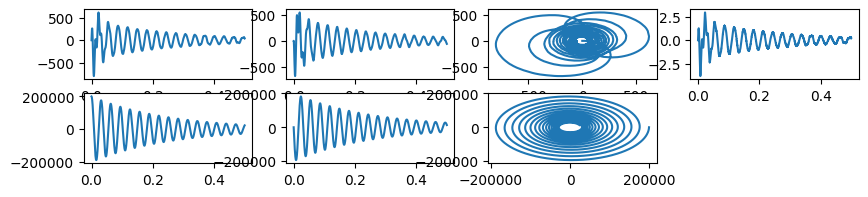

In [21]:
x = load_data(itraj=1, what="hidden_state.npy")
dy = load_data(itraj=1,what="dys.npy")
f = load_data(itraj=1, what="external_signal.npy")

params, exp_path = give_params()

####
gamma, omega, n, eta, kappa, b,[periods, ppp] = params
period = (2*np.pi/omega)
total_time = period*periods
dt = period/ppp

times = np.arange(0,total_time,dt)
if len(times)>1e4:
    indis = np.linspace(0,len(times)-1, int(1e4)).astype(int)
else:
    indis = np.arange(0,len(times))
timind = [times[ind] for ind in indis]


plt.figure(figsize=(10,2))
ax=plt.subplot(241)
ax.plot(timind,x[:,0])
ax=plt.subplot(242)
ax.plot(timind,x[:,1])
ax=plt.subplot(243)
ax.plot(x[:,0],x[:,1])
ax=plt.subplot(244)
ax.plot(timind,dy[:,0])
ax=plt.subplot(245)
ax.plot(timind,f[:,0])
ax=plt.subplot(246)
ax.plot(timind,f[:,1])
ax=plt.subplot(247)
ax.plot(f[:,0],f[:,1])

In [22]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.linalg import solve_continuous_are


In [23]:
params

[94.24777960769379,
 628.3185307179587,
 14.0,
 1.0,
 2261.946710584651,
 [200.0, 5],
 [50, 200]]

In [27]:
class GRNN(torch.nn.Module):
    def __init__(self,inputs_cell):
        super(GRNN, self).__init__()
        
        self.dt, self.simulation_params, omega_initial = inputs_cell
        gamma, omega, n, eta, kappa, b = self.simulation_params 
        #self.omega_p = torch.nn.Parameter(data = torch.tensor([omega_initial],dtype=torch.float32,
        #                                                      requires_grad=True))
        
        self.proj_C = torch.tensor(data=[[1.,0.],[0.,0.]], dtype=torch.float32).detach()
        
        self.A = torch.tensor(data = [[-gamma/2, omega],[-omega, -gamma/2]], dtype=torch.float32)
        self.C = np.sqrt(4*eta*kappa)*self.proj_C.detach()
        self.D = (gamma*(n+0.5) + kappa)*torch.eye(2).detach()
        #self.coeffs_f = torch.nn.Parameter(data = torch.tensor(2*torch.ones((4,2)), dtype=torch.float32,
        #                                                              requires_grad = True))
        omega_f, gamma_f = 2e2, 5
        initial_data_f = [ [-gamma_f,-omega_f], [omega_f, -gamma_f], [0., 0.], [0., 0.] ] #be careful, A-->A^T here
        self.coeffs_f = torch.nn.Parameter(data = torch.tensor(initial_data_f, dtype=torch.float32,
                                                                      requires_grad = True))
        
        
    def forward(self, dy, state):
        """
        input_data is dy
        hidden_state is x: (<q>, <p>, Var[x], Var[p], Cov(q,q)})
        output dy_hat
        """
        x = state[:2]
        [vx,vp,cxp] = state[2:5]
        f = state[5:]
        cov = torch.tensor(data = [[vx,cxp],[cxp,vp]], dtype=torch.float32)
        
        xicov = cov.matmul(self.C.T)
        
        dx = (self.A - xicov.matmul(self.C)).matmul(x)*dt + xicov.matmul(dy)
        
        ### signal part 
        #### g0(f) = f, g1(f) = f**3
        dictionary = torch.concatenate([f, f**3])
        
        df = self.dt*dictionary.matmul(self.coeffs_f) ###Check this!
        fnew = f+ df
        
        dx += fnew*self.dt
        
        dcov = self.dt*(cov.matmul(self.A.T) + (self.A).matmul(cov) + self.D - (xicov.matmul(xicov.T)))
        ncov = cov+dcov
        nstate = torch.concatenate([(x + dx), torch.tensor([ncov[0,0],ncov[1,1],ncov[1,0]]), fnew])

        dy_hat = self.C.matmul(x)*self.dt

        return nstate, dy_hat

class RecurrentNetwork(torch.nn.Module):
    def __init__(self,inputs_cell):
        super(RecurrentNetwork, self).__init__()
        self.RCell = GRNN(inputs_cell=inputs_cell)
        self.params = inputs_cell[1]
        
    def forward(self, dys):
        dys_hat = []
        
        ### Find stationary value of covariance for the parameter RCell currently has
        gamma, omega, n, eta, kappa, b = self.params 
        #omega_p = self.RCell.omega_p.detach().numpy()[0]
        A = np.array([[-gamma/2, omega],[-omega, -gamma/2]])
        proj_C = np.array([[1.,0.],[0.,0.]])
        C = np.sqrt(4*eta*kappa)*proj_C
        D = np.diag([gamma*(n+0.5) + kappa]*2)
        G = np.zeros((2,2))
        Cov = solve_continuous_are((A-G.dot(C)).T, C.T, D- (G.T).dot(G), np.eye(2)) #### A.T because the way it's implemented!
        
        xs_hat = [torch.tensor([0., 0., Cov[0,0], Cov[1,1],Cov[1,0], 2e5, 0.], dtype=torch.float32)]
        x_hat = xs_hat[0]
        for dy_t in dys:
            x_hat, dy_hat = self.RCell(dy_t, x_hat)
            dys_hat += [dy_hat]
            xs_hat += [x_hat]
        return torch.stack(xs_hat), torch.stack(dys_hat)

In [28]:

params, exp_path = give_params()

####
gamma, omega, n, eta, kappa, params_force ,[periods, ppp] = params
period = (2*np.pi/omega)
total_time = period*periods
dt = period/ppp

times = np.arange(0,total_time+dt,dt)




A = np.array([[-gamma/2, omega],[-omega, -gamma/2]])
proj_C = np.array([[1.,0.],[0.,0.]])
C = np.sqrt(4*eta*kappa)*proj_C
D = np.diag([gamma*(n+0.5) + kappa]*2)
G = np.zeros((2,2))

Cov = solve_continuous_are((A-G.dot(C)).T, C.T, D- (G.T).dot(G), np.eye(2)) #### A.T because the way it's implemented!
XiCov = Cov.dot(C.T) + G.T



In [29]:
omega_initial = omega
inputs_cell = [dt,  [gamma, omega, n, eta, kappa, params_force], omega_initial]

x = load_data(itraj=1, what="hidden_state.npy")
dy = load_data(itraj=1,what="dys.npy")

dev = torch.device("cpu")
rrn = RecurrentNetwork(inputs_cell)
dys = torch.tensor(data=dy, dtype=torch.float32).to(dev)

In [30]:
xs_hat, dys_hat = rrn(dys)

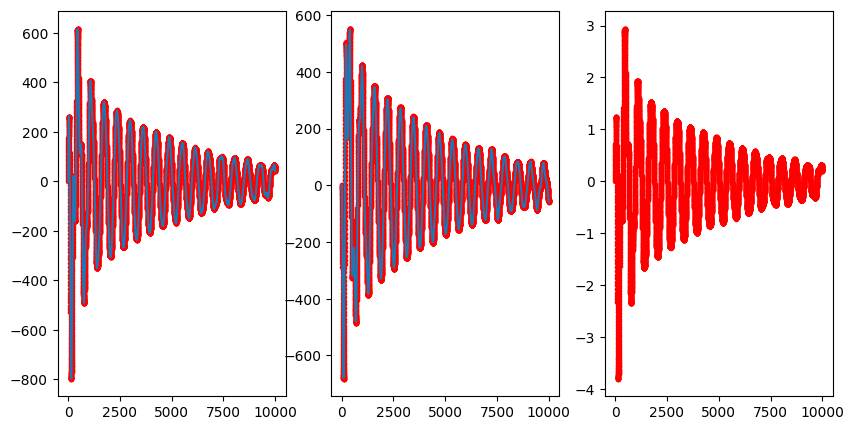

In [31]:
plt.figure(figsize=(10,5))

ax=plt.subplot(131)
ax.plot(xs_hat.detach().numpy()[:,0], color="red",marker='.')
ax.plot(x[:,0])
ax=plt.subplot(132)
ax.plot(xs_hat.detach().numpy()[:,1], color="red",marker='.')
ax.plot(x[:,1])
ax=plt.subplot(133)
ax.plot(dys[:,0])
ax.plot(dys_hat.detach().numpy()[:,0], color="red",marker='.')


# Training

In [32]:
def log_lik(dys, dys_hat):
    return torch.sum((dys-dys_hat)**2)/(dt*len(dys))

In [33]:
list(rrn.parameters())

[Parameter containing:
 tensor([[  -5., -200.],
         [ 200.,   -5.],
         [   0.,    0.],
         [   0.,    0.]], requires_grad=True)]

In [34]:
x = load_data(itraj=1, what="hidden_state.npy")
dy = load_data(itraj=1,what="dys.npy")

In [38]:
dev = torch.device("cpu")
rrn = RecurrentNetwork(inputs_cell)
dys = torch.tensor(data=dy, dtype=torch.float32).to(dev)

xs_hat, dys_hat = rrn(dys)

In [39]:
cost = log_lik(dys_hat, dys)

In [40]:
cost.backward()

In [42]:
rrn.RCell.coeffs_f.grad

tensor([[-1.7629e-02, -2.5494e-01],
        [ 2.5348e-01, -1.2041e-02],
        [-1.7987e+08, -4.1468e+09],
        [ 4.1000e+09, -3.7270e+07]])

In [372]:
x = load_data(itraj=1, what="hidden_state.npy")
dy = load_data(itraj=1,what="dys.npy")


omegas_landscape = np.linspace(0.05*omega, 5*omega, 11)

loss_landscape = {}
for o in tqdm(omegas_landscape):

    inputs_cell = [dt,  [gamma, omega, n, eta, kappa, b], o]



    dev = torch.device("cpu")
    rrn = RecurrentNetwork(inputs_cell)
    dys = torch.tensor(data=dy, dtype=torch.float32).to(dev)

    xs_hat, dys_hat = rrn(dys)
    loss_landscape[o] = log_lik(dys, dys_hat)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:20<00:00,  1.85s/it]


Text(0, 0.5, '$L(\\omega)$')

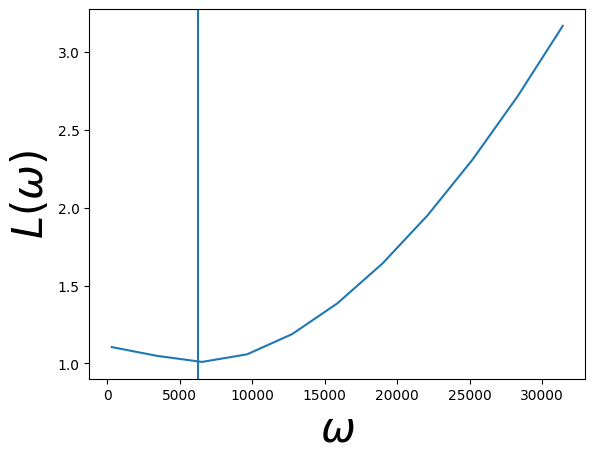

In [375]:
plt.figure()
ax = plt.subplot()
ax.plot(omegas_landscape, torch.stack(list(loss_landscape.values())).detach().numpy())
ax.axvline(omega)
ax.set_xlabel(r'$\omega$',size=30)
ax.set_ylabel(r'$L(\omega)$',size=30)

In [24]:
log_lik(dys,dys_hat)

tensor(1.0092, grad_fn=<DivBackward0>)

In [381]:
inputs_cell = [dt,  [gamma, omega, n, eta, kappa, b], 10*omega]

x = load_data(itraj=1, what="hidden_state.npy")
dy = load_data(itraj=1,what="dys.npy")

dev = torch.device("cpu")
rrn = RecurrentNetwork(inputs_cell)


In [427]:
inputs_cell = [dt,  [gamma, omega, n, eta, kappa, b], 3*omega]

x = load_data(itraj=1, what="hidden_state.npy")
dy = load_data(itraj=1,what="dys.npy")

dev = torch.device("cpu")
rrn = RecurrentNetwork(inputs_cell)


optimizer = torch.optim.Adam(list(rrn.parameters()), lr=1e3)

dys = torch.tensor(data=dy, dtype=torch.float32).to(torch.device("cpu"))

history = {}
history["losses"] = []
history["params"] = []
history["gradients"] = []

for ind in tqdm(range(100)):
    xs_hat, dys_hat = rrn(dys)
    loss = log_lik(dys, dys_hat)
    loss.backward()
    
    optimizer.step()
    history["losses"].append(loss.item())
    history["params"].append(rrn.RCell.omega_p.detach().numpy()[0])
    history["gradients"].append(rrn.RCell.omega_p.grad.numpy())
    
    print(loss.item())
    
    optimizer.zero_grad()

  1%|█                                                                                                      | 1/100 [00:02<04:02,  2.45s/it]

1.6292939186096191


  2%|██                                                                                                     | 2/100 [00:04<03:58,  2.44s/it]

1.541772723197937


  3%|███                                                                                                    | 3/100 [00:07<03:55,  2.43s/it]

1.4600725173950195


  4%|████                                                                                                   | 4/100 [00:09<03:58,  2.48s/it]

1.3844443559646606


  5%|█████▏                                                                                                 | 5/100 [00:12<03:57,  2.50s/it]

1.3151458501815796


  6%|██████▏                                                                                                | 6/100 [00:15<04:07,  2.64s/it]

1.2524434328079224


  7%|███████▏                                                                                               | 7/100 [00:17<04:01,  2.60s/it]

1.1966019868850708


  8%|████████▏                                                                                              | 8/100 [00:20<03:52,  2.53s/it]

1.1478761434555054


  9%|█████████▎                                                                                             | 9/100 [00:22<03:50,  2.54s/it]

1.1064900159835815


 10%|██████████▏                                                                                           | 10/100 [00:26<04:08,  2.76s/it]

1.0726054906845093


 11%|███████████▏                                                                                          | 11/100 [00:28<03:59,  2.69s/it]

1.046271800994873


 12%|████████████▏                                                                                         | 12/100 [00:31<03:52,  2.64s/it]

1.0273581743240356


 13%|█████████████▎                                                                                        | 13/100 [00:33<03:47,  2.62s/it]

1.015472650527954


 14%|██████████████▎                                                                                       | 14/100 [00:36<03:40,  2.57s/it]

1.0098941326141357


 15%|███████████████▎                                                                                      | 15/100 [00:38<03:32,  2.50s/it]

1.0095490217208862


 16%|████████████████▎                                                                                     | 16/100 [00:40<03:26,  2.46s/it]

1.0130764245986938


 17%|█████████████████▎                                                                                    | 17/100 [00:43<03:22,  2.44s/it]

1.0189900398254395


 18%|██████████████████▎                                                                                   | 18/100 [00:45<03:18,  2.42s/it]

1.025891661643982


 19%|███████████████████▍                                                                                  | 19/100 [00:47<03:14,  2.40s/it]

1.0326563119888306


 20%|████████████████████▍                                                                                 | 20/100 [00:50<03:10,  2.38s/it]

1.0385165214538574


 21%|█████████████████████▍                                                                                | 21/100 [00:52<03:07,  2.37s/it]

1.0430433750152588


 22%|██████████████████████▍                                                                               | 22/100 [00:54<03:04,  2.37s/it]

1.046064019203186


 23%|███████████████████████▍                                                                              | 23/100 [00:57<03:01,  2.36s/it]

1.0475677251815796


 24%|████████████████████████▍                                                                             | 24/100 [00:59<02:57,  2.33s/it]

1.0476328134536743


 25%|█████████████████████████▌                                                                            | 25/100 [01:01<02:56,  2.35s/it]

1.0463849306106567


 26%|██████████████████████████▌                                                                           | 26/100 [01:04<02:53,  2.34s/it]

1.0439825057983398


 27%|███████████████████████████▌                                                                          | 27/100 [01:06<02:50,  2.34s/it]

1.0406163930892944


 28%|████████████████████████████▌                                                                         | 28/100 [01:08<02:48,  2.34s/it]

1.0365158319473267


 29%|█████████████████████████████▌                                                                        | 29/100 [01:12<03:02,  2.56s/it]

1.0319477319717407


 30%|██████████████████████████████▌                                                                       | 30/100 [01:14<02:56,  2.52s/it]

1.0272090435028076


 31%|███████████████████████████████▌                                                                      | 31/100 [01:16<02:49,  2.46s/it]

1.0226044654846191


 32%|████████████████████████████████▋                                                                     | 32/100 [01:19<02:46,  2.45s/it]

1.0184197425842285


 33%|█████████████████████████████████▋                                                                    | 33/100 [01:21<02:43,  2.44s/it]

1.0148895978927612


 34%|██████████████████████████████████▋                                                                   | 34/100 [01:23<02:39,  2.42s/it]

1.012173056602478


 35%|███████████████████████████████████▋                                                                  | 35/100 [01:26<02:35,  2.40s/it]

1.0103389024734497


 36%|████████████████████████████████████▋                                                                 | 36/100 [01:28<02:32,  2.38s/it]

1.0093648433685303


 37%|█████████████████████████████████████▋                                                                | 37/100 [01:31<02:29,  2.37s/it]

1.0091485977172852


 38%|██████████████████████████████████████▊                                                               | 38/100 [01:33<02:26,  2.36s/it]

1.0095289945602417


 39%|███████████████████████████████████████▊                                                              | 39/100 [01:35<02:24,  2.36s/it]

1.0103119611740112


 40%|████████████████████████████████████████▊                                                             | 40/100 [01:38<02:22,  2.37s/it]

1.0112959146499634


 41%|█████████████████████████████████████████▊                                                            | 41/100 [01:40<02:20,  2.38s/it]

1.0122956037521362


 42%|██████████████████████████████████████████▊                                                           | 42/100 [01:43<02:21,  2.45s/it]

1.0131583213806152


 43%|███████████████████████████████████████████▊                                                          | 43/100 [01:45<02:22,  2.50s/it]

1.0137760639190674


 44%|████████████████████████████████████████████▉                                                         | 44/100 [01:48<02:21,  2.52s/it]

1.0140883922576904


 45%|█████████████████████████████████████████████▉                                                        | 45/100 [01:50<02:15,  2.46s/it]

1.0140820741653442


 46%|██████████████████████████████████████████████▉                                                       | 46/100 [01:53<02:12,  2.46s/it]

1.0137832164764404


 47%|███████████████████████████████████████████████▉                                                      | 47/100 [01:55<02:11,  2.49s/it]

1.0132497549057007


 48%|████████████████████████████████████████████████▉                                                     | 48/100 [01:59<02:24,  2.78s/it]

1.0125588178634644


 49%|█████████████████████████████████████████████████▉                                                    | 49/100 [02:01<02:17,  2.70s/it]

1.0117948055267334


 50%|███████████████████████████████████████████████████                                                   | 50/100 [02:04<02:12,  2.66s/it]

1.0110398530960083


 51%|████████████████████████████████████████████████████                                                  | 51/100 [02:06<02:07,  2.61s/it]

1.0103634595870972


 52%|█████████████████████████████████████████████████████                                                 | 52/100 [02:09<02:07,  2.66s/it]

1.0098167657852173


 53%|██████████████████████████████████████████████████████                                                | 53/100 [02:11<02:02,  2.60s/it]

1.0094289779663086


 54%|███████████████████████████████████████████████████████                                               | 54/100 [02:14<01:58,  2.58s/it]

1.0092072486877441


 55%|████████████████████████████████████████████████████████                                              | 55/100 [02:16<01:53,  2.52s/it]

1.0091381072998047


 56%|█████████████████████████████████████████████████████████                                             | 56/100 [02:19<01:48,  2.47s/it]

1.0091934204101562


 57%|██████████████████████████████████████████████████████████▏                                           | 57/100 [02:21<01:44,  2.43s/it]

1.009334921836853


 58%|███████████████████████████████████████████████████████████▏                                          | 58/100 [02:23<01:40,  2.40s/it]

1.0095208883285522


 59%|████████████████████████████████████████████████████████████▏                                         | 59/100 [02:26<01:37,  2.38s/it]

1.0097122192382812


 60%|█████████████████████████████████████████████████████████████▏                                        | 60/100 [02:28<01:34,  2.36s/it]

1.009876012802124


 61%|██████████████████████████████████████████████████████████████▏                                       | 61/100 [02:30<01:32,  2.36s/it]

1.0099889039993286


 62%|███████████████████████████████████████████████████████████████▏                                      | 62/100 [02:33<01:29,  2.34s/it]

1.0100390911102295


 63%|████████████████████████████████████████████████████████████████▎                                     | 63/100 [02:35<01:26,  2.33s/it]

1.0100245475769043


 64%|█████████████████████████████████████████████████████████████████▎                                    | 64/100 [02:37<01:23,  2.33s/it]

1.0099529027938843


 65%|██████████████████████████████████████████████████████████████████▎                                   | 65/100 [02:40<01:21,  2.32s/it]

1.0098377466201782


 66%|███████████████████████████████████████████████████████████████████▎                                  | 66/100 [02:42<01:19,  2.33s/it]

1.0096970796585083


 67%|████████████████████████████████████████████████████████████████████▎                                 | 67/100 [02:45<01:23,  2.54s/it]

1.0095492601394653


 68%|█████████████████████████████████████████████████████████████████████▎                                | 68/100 [02:47<01:19,  2.48s/it]

1.0094109773635864


 69%|██████████████████████████████████████████████████████████████████████▍                               | 69/100 [02:50<01:15,  2.45s/it]

1.0092953443527222


 70%|███████████████████████████████████████████████████████████████████████▍                              | 70/100 [02:52<01:12,  2.41s/it]

1.0092103481292725


 71%|████████████████████████████████████████████████████████████████████████▍                             | 71/100 [02:54<01:09,  2.39s/it]

1.009158730506897


 72%|█████████████████████████████████████████████████████████████████████████▍                            | 72/100 [02:57<01:06,  2.37s/it]

1.009138822555542


 73%|██████████████████████████████████████████████████████████████████████████▍                           | 73/100 [02:59<01:03,  2.36s/it]

1.00914466381073


 74%|███████████████████████████████████████████████████████████████████████████▍                          | 74/100 [03:01<01:01,  2.35s/it]

1.0091683864593506


 75%|████████████████████████████████████████████████████████████████████████████▌                         | 75/100 [03:04<00:58,  2.36s/it]

1.0092008113861084


 76%|█████████████████████████████████████████████████████████████████████████████▌                        | 76/100 [03:06<00:56,  2.35s/it]

1.009233832359314


 77%|██████████████████████████████████████████████████████████████████████████████▌                       | 77/100 [03:08<00:53,  2.34s/it]

1.0092604160308838


 78%|███████████████████████████████████████████████████████████████████████████████▌                      | 78/100 [03:11<00:51,  2.34s/it]

1.009276270866394


 79%|████████████████████████████████████████████████████████████████████████████████▌                     | 79/100 [03:13<00:49,  2.34s/it]

1.0092796087265015


 80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 80/100 [03:15<00:47,  2.35s/it]

1.0092707872390747


 81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 81/100 [03:18<00:44,  2.35s/it]

1.0092524290084839


 82%|███████████████████████████████████████████████████████████████████████████████████▋                  | 82/100 [03:20<00:43,  2.40s/it]

1.009227991104126


 83%|████████████████████████████████████████████████████████████████████████████████████▋                 | 83/100 [03:23<00:40,  2.38s/it]

1.0092016458511353


 84%|█████████████████████████████████████████████████████████████████████████████████████▋                | 84/100 [03:25<00:38,  2.38s/it]

1.0091772079467773


 85%|██████████████████████████████████████████████████████████████████████████████████████▋               | 85/100 [03:27<00:35,  2.37s/it]

1.0091575384140015


 86%|███████████████████████████████████████████████████████████████████████████████████████▋              | 86/100 [03:30<00:36,  2.58s/it]

1.00914466381073


 87%|████████████████████████████████████████████████████████████████████████████████████████▋             | 87/100 [03:33<00:32,  2.51s/it]

1.0091387033462524


 88%|█████████████████████████████████████████████████████████████████████████████████████████▊            | 88/100 [03:35<00:29,  2.46s/it]

1.0091391801834106


 89%|██████████████████████████████████████████████████████████████████████████████████████████▊           | 89/100 [03:37<00:26,  2.42s/it]

1.009144902229309


 90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 90/100 [03:40<00:23,  2.39s/it]

1.0091536045074463


 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 91/100 [03:42<00:21,  2.40s/it]

1.0091631412506104


 92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 92/100 [03:44<00:18,  2.37s/it]

1.0091716051101685


 93%|██████████████████████████████████████████████████████████████████████████████████████████████▊       | 93/100 [03:47<00:16,  2.36s/it]

1.0091776847839355


 94%|███████████████████████████████████████████████████████████████████████████████████████████████▉      | 94/100 [03:49<00:14,  2.37s/it]

1.0091805458068848


 95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 95/100 [03:52<00:11,  2.36s/it]

1.009179949760437


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▉    | 96/100 [03:54<00:09,  2.35s/it]

1.009176254272461


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▉   | 97/100 [03:56<00:07,  2.35s/it]

1.0091702938079834


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▉  | 98/100 [03:59<00:04,  2.34s/it]

1.0091631412506104


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 99/100 [04:01<00:02,  2.35s/it]

1.0091559886932373


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:03<00:00,  2.44s/it]

1.009149432182312


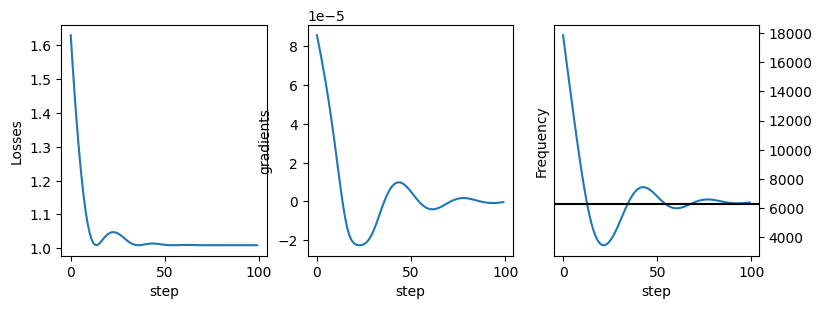

In [431]:
plt.figure(figsize=(9,3))
ax=plt.subplot(131)
ax.plot(history["losses"])
ax.set_xlabel("step")
ax.set_ylabel("Losses")

ax=plt.subplot(132)
ax.plot(history["gradients"])
ax.set_xlabel("step")
ax.set_ylabel("gradients")

ax=plt.subplot(133)
ax.plot(history["params"])
ax.set_ylabel("Frequency")
ax.set_xlabel("step")
ax.axhline(omega, color="black")
ax.yaxis.tick_right()

In [423]:
inputs_cell = [dt,  [gamma, omega, n, eta, kappa, b], 10*omega]

x = load_data(itraj=1, what="hidden_state.npy")
dy = load_data(itraj=1,what="dys.npy")

dev = torch.device("cpu")
rrn = RecurrentNetwork(inputs_cell)


optimizer = torch.optim.SGD(list(rrn.parameters()), lr=1e2)

dys = torch.tensor(data=dy, dtype=torch.float32).to(torch.device("cpu"))

history = {}
history["losses"] = []
history["params"] = []
history["gradients"] = []

for ind in tqdm(range(30)):
    xs_hat, dys_hat = rrn(dys)
    loss = log_lik(dys, dys_hat)
    loss.backward()
    optimizer.step()
    history["losses"].append(loss.item())
    history["params"].append(rrn.RCell.omega_p.detach().numpy()[0])
    history["gradients"].append(rrn.RCell.omega_p.grad.numpy())
    
    optimizer.zero_grad()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:12<00:00,  2.40s/it]


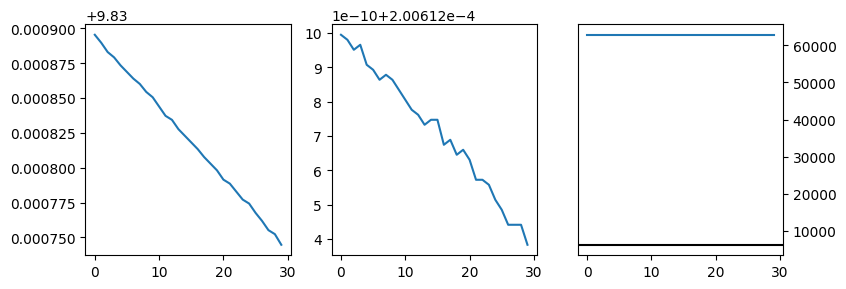

In [414]:
plt.figure(figsize=(9,3))
ax=plt.subplot(131)
ax.plot(history["losses"])
ax=plt.subplot(132)
ax.plot(history["gradients"])
ax=plt.subplot(133)
ax.plot(history["params"])
ax.axhline(omega, color="black")
ax.yaxis.tick_right()

In [155]:
history["params"]

[array([188495.52], dtype=float32),
 array([188495.52], dtype=float32),
 array([188495.52], dtype=float32)]

In [224]:
history["losses"]

[2739.5009765625, 2739.61669921875, 2739.026611328125]

In [648]:
RNN.zero_grad()
optimizer.zero_grad()

In [650]:
RNN.RCell.zero_grad()

In [274]:
class CustomModel(torch.nn.Module):
    def __init__(self,w0):
        super(CustomModel, self).__init__()
        self.w = torch.nn.Parameter(data = torch.tensor([w0], dtype=torch.float32, requires_grad=True))
        
        #self.matrix = torch.tensor(data = [[self.w, -1.],[-self.w, -1.]], dtype=torch.float32, requires_grad=True    This computes \partial_matrix(COST)
        self.matrix_trainable = self.w*torch.tensor(data=[[0,1],[-1,0]], dtype=torch.float32,requires_grad=False)
        self.matrix = self.matrix_trainable - torch.eye(2)
        
    def forward(self, x):
        return self.matrix.matmul(x)
    
def loss(pred,y):
    return torch.mean((pred- y)**2)


my_model = CustomModel(w0=0.01)
optimizer = torch.optim.Adam(lr=0.01, params=my_model.parameters())

device = torch.device("cpu")
x = torch.ones(2).to(device)
y = torch.tensor(data=[2.,0.], dtype=torch.float32).to(device)


for k in range(10):

    optimizer.zero_grad()
    my_model.zero_grad()
    pred = my_model(x)
    cost = loss(pred,y)
    cost.backward()
    optimizer.step()

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [271]:
my_model.w.grad

tensor([-1.9800])

/tmp/ipykernel_8095/2094205978.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:486.)
  my_model.matrix.grad


In [263]:
torch.__version__

'2.0.1+cu117'

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [221]:
dev = torch.device("cpu")


[Parameter containing:
 tensor([0.0100], requires_grad=True)]

In [220]:
loss(x,y)


AttributeError: 'function' object has no attribute 'backward'

In [214]:
class CustomModel(torch.nn.Module):
    def __init__(self,w0):
        super(CustomModel, self).__init__()
        self.w = torch.nn.Parameter(data = torch.tensor([w0], dtype=torch.float32, requires_grad=True))
            
            
    def forward(self, dy, x):
        """
        input_data is dy
        hidden_state is x
        output dy_hat
        """
       # dx = torch.matmul(torch.tensor(data = [[0,1],[-1,0]], dtype=torch.float32)*self.omega_p
        #                  + torch.tensor(data = -0.5*gamma*np.eye(2), dtype=torch.float32)- self.xicovC,x)*dt + torch.matmul(self.xicov,dy)
        # That works!
      #  dx = #self.A_symp.matmul(x)*dt#- self.xicovC).matmul(x)*dt + torch.matmul(self.xicov,dy)
       # dx = self.A_body.matmul(x)*dt
        #ss = torch.tensor(data = [[0,1],[-1,0]], dtype=torch.float32, requires_grad=True)
        #A = ss*self.omega_p + self.A_diag
        dx = self.omega_p*(AA-xicov.matmul(x)*dt 
        dy_hat = self.C.matmul(x)*self.dt
        return torch.stack([x + dx, dy_hat])

class RecurrentNetwork(torch.nn.Module):
    def __init__(self,inputs_cell):
        super(RecurrentNetwork, self).__init__()
        self.RCell = RecurrentCell(inputs_cell=inputs_cell)

    def forward(self, dys):
        dys_hat = []
        xs_hat = [torch.tensor([0., 0.],dtype=torch.float32)]
        x_hat = xs_hat[0]
        for dy_t in dys:
            x_hat, dy_hat = self.RCell(dy_t, x_hat)
            dys_hat += [dy_hat]
            xs_hat += [x_hat]
        return torch.stack(xs_hat), torch.stack(dys_hat)

SyntaxError: '(' was never closed (3996344217.py, line 20)

In [651]:
xs_hat, dys_hat = RNN(dys)
loss = log_lik(dys, dys_hat)
loss.backward()
optimizer.step()


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [ ]:
torch.

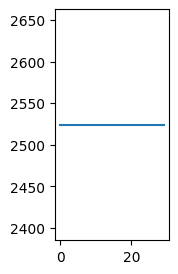

In [635]:
plt.figure(figsize=(5,3))
ax=plt.subplot(131)
ax.plot(history["losses"])

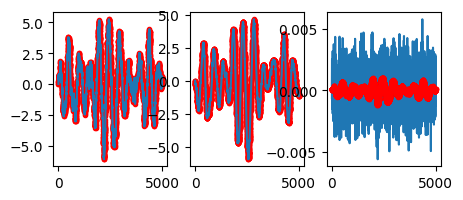

In [421]:
plt.figure(figsize=(5,2))
ax=plt.subplot(131)
ax.plot(xs_hat.detach().numpy()[:,0], color="red",marker='.')
ax.plot(x[:,0])
ax=plt.subplot(132)
ax.plot(xs_hat.detach().numpy()[:,1], color="red",marker='.')
ax.plot(x[:,1])
ax=plt.subplot(133)
ax.plot(dys[:,0])
ax.plot(dys_hat.detach().numpy()[:,0], color="red",marker='.')

In [422]:

def log_lik(dys, dys_hat):
    return torch.sum((dys-dys_hat)**2)/(2*dt)

In [423]:
dev = torch.device("cpu")
optimizer = torch.optim.Adam(lr=0.01, params=rrn.parameters())

In [445]:
Recurrent = RecurrentNetwork(inputs_cell)

In [446]:
dys = torch.tensor(data=dy, dtype=torch.float32).to(dev)#.detach().requires_grad_(True)

In [447]:
xs_hat, dys_hat = Recurrent(dys)
#xs_hat, dys_hat = rrn(dys)

In [448]:
Recurrent.RCell.omega_p.is_leaf

True

In [449]:
rrn.zero_grad()
optimizer.zero_grad()

In [450]:
cost = log_lik(dys,dys_hat)
#cost.detach().requires_grad_(True)

In [451]:
cost.backward()

In [441]:
rrn.RCell.omega_p.detach().requires_grad_(True)

tensor([6283.1855], requires_grad=True)

In [385]:
rrn.RCell.omega_p.grad

In [49]:
class RecurrentCell(torch.nn.Module):
    def __init__(self, dt=0.001):
        super(RecurrentCell, self).__init__()
        self.params = torch.nn.Parameter(data = torch.tensor([11, 8/3, 28],dtype=torch.float32, requires_grad=True))
        self.dt = dt

    def forward(self, input_data, hidden_state):
        sigma, beta, rho = self.params
        x,y,z = hidden_state
        dx, dy, dz = sigma*(y-x), x*(rho-z) -y, x*y - beta*z
        return torch.stack([x+dx*self.dt, y+dy*self.dt, z+dz*self.dt])

class RecurrentNetwork(nn.Module):
    def __init__(self,dt=0.001):
        super(RecurrentNetwork, self).__init__()
        self.RCell = RecurrentCell(dt=dt)

    def forward(self, input):
        outputs = []
        h_t = torch.tensor([-8,7,27],dtype=torch.float32)
        for i, input_t in enumerate(input):
            h_t = self.RCell(None, h_t)
            outputs += [h_t]
        
        outputs = torch.stack(outputs)
        return outputs

In [68]:
Rnn = RecurrentNetwork()
times = torch.arange(0,100,0.001)
outs = Rnn(times)

In [69]:
optimizer = torch.optim.SGD(Rnn.parameters(), lr=0.01)

def MSE(output, target):
    loss = torch.mean((output - target)**2)
    return loss

In [70]:
target_traj  = np.load("data/lorenz/0_1_0.001.npy")
target = torch.tensor(target_traj,dtype=torch.float32).reshape([1000,3])
Rnn.train()

RecurrentNetwork(
  (RCell): RecurrentCell()
)

In [71]:
X = torch.tensor(times).to("cpu")
Y = target.to("cpu")
history = {}
history["losses"] = []
history["params"] = []
history["gradients"] = []

for ind in tqdm(range(30)):
        
    pred = Rnn(X)
    loss = MSE(pred, Y)
    loss.backward()
    optimizer.step()
    
    history["losses"].append(loss.item())
    history["params"].append(list(Rnn.parameters())[0].detach().numpy())
    history["gradients"].append(Rnn.RCell.params.grad.numpy())

    optimizer.zero_grad()


/tmp/ipykernel_2711/2538995262.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(times).to("cpu")
100%|██████████| 30/30 [00:18<00:00,  1.65it/s]


In [73]:
pred = Rnn(X)
loss = MSE(pred, Y)
loss.backward()

tensor([ 1.1262, -2.3285,  5.9817])

Text(0.5, 0.92, 'Lorenz Attractor')

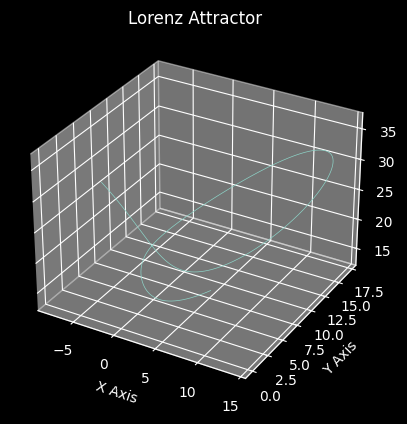

In [34]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot(*outs.detach().numpy().T,lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

tensor([[-7.8500,  7.1877, 26.1880],
        [-7.6996,  7.3651, 25.3983],
        [-7.5490,  7.5328, 24.6304],
        ...,
        [ 6.8314,  6.8313,  1.6667],
        [ 6.8314,  6.8313,  1.6667],
        [ 6.8314,  6.8313,  1.6667]], grad_fn=<StackBackward0>)

In [ ]:

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Train the network

for epoch in range(epochs):
    for batch, (data, target) in enumerate(train_loader):
        # Obtaining the cuda parameters
        data = data.to(device=device)
        target = target.to(device=device)

        # Reshaping to suit our model
        data = data.reshape(data.shape[0], -1)

        # Forward propagation
        score = model(data)
        loss = criterion(score, target)

        # Backward propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [2]:
@jit(nopython=True)
def f(x,t,sigma=10, beta=8/3,rho=28):
    X,Y,Z = x
    return np.array([sigma*(Y-X), X*(rho-Z)-Y, X*Y - (beta*Z)])
@jit(nopython=True)aaaaa
def g(x,t):
    return np.zeros(3)

In [3]:
dt = 0.001
times = np.arange(0,100,dt)
x0=np.array([-8,7,27])
xx1 = integrate(f,g,x0,times,dt,mode="euler")
xx2 = integrate(f,g,x0,times,dt,mode="RK4")

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

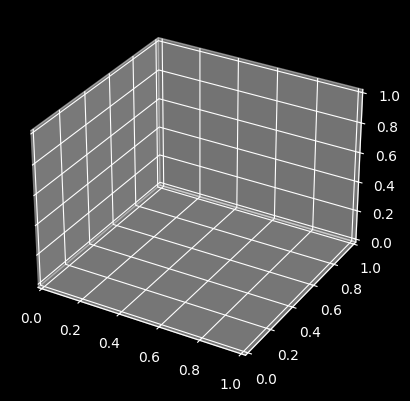

In [9]:
import os 

os.makedirs("data/trajs/lorenz/",exist_ok=True)
np.save("data/trajs/lorenz/1",xx1)